# Nim game

In [352]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy

## The _Nim_ and _Nimply_ classes


In [353]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [354]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

- Class `Nim` is defined, with an initializer method `__init__`, three methods `__bool__`, `__str__`, and `nimming`, and a property `rows`.
- The `__init__` method takes two arguments: `num_rows` and `k` (with a default value of `None`), and initializes `self._rows` with a list of odd numbers and stores `k` in `self._k`.
- The `__bool__` method returns a boolean value indicating whether the sum of the numbers in `self._rows` is greater than 0.
- The `__str__` method returns a string representation of the `Nim` instance by joining the numbers in `self._rows` into a string enclosed in angle brackets.
- The `rows` property returns a tuple containing the numbers in `self._rows`.
- The `nimming` method takes a `Nimply` instance (or a tuple), unpacks it into `row` and `num_objects`, and performs two assertions. It subtracts `num_objects` from the number of objects in the specified row if both assertions pass.


## Sample (and silly) startegies


In [355]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice(
        [r for r, c in enumerate(state.rows) if c > 0]
    )  # select random non empty row
    num_objects = random.randint(
        1, state.rows[row]
    )  # select random number of objects to be removed from row
    return Nimply(
        row, num_objects
    )  # return new Nimply object for that row with updated number of objects

In [356]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [
        (r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)
    ]  # create list of all possible moves
    return Nimply(
        *max(possible_moves, key=lambda m: (-m[0], m[1]))
    )  # return Nimply object with maximum number of objects from lowest row

In [357]:
def adaptive_strategy(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}  # set initial value for love_small

    if state.rows[0] <= 3:  # if lowest row has 3 or less objects
        genome["love_small"] = 0.9  # increase love_small
    elif state.rows[0] >= 7:  # if lowest row has 7 or more objects
        genome["love_small"] = 0.1  # decrease love_small

    row = min(
        range(len(state.rows)), key=lambda r: state.rows[r]
    )  # select row with lowest number of objects

    num_objects = int(
        genome["love_small"] * state.rows[row]
    )  # select number of objects to be removed from row

    return Nimply(
        row, num_objects
    )  # return Nimply object for that row with updated number of objects

In [358]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply

## Oversimplified match

In [ ]:
logging.getLogger().setLevel(logging.INFO)

# genome={"target_preference":0.5}
# adaptive = adaptive_strategy(genome)
strategy = (pure_random, optimal)

nim = Nim(5)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")

# ES strategy definition

In [360]:
from tqdm import tqdm
import numpy as np
import random

In [361]:
# Strategy rules
N_RULES = 6
N_HEAP_RULES = 2
N_OBJ_RULES = 4

# ES parameters
N_GEN = 200
POPULATION_SIZE = 50
N_PARENTS = POPULATION_SIZE//3
MUTATION_RATE = 0.15
FITNESS_MATCHES = 200
TOURNAMENT_SIZE = 25

# Game dimension
NIM_DIM = 5

## Rule based strategy
A strategy is defined by a set of rules of heap and object selections and they're represented as a set of weights which set the probability to use that rule.

Heap selection rules:
1. Random selection
2. Fattest heap selection

Object selection rules:
1. Random selection
2. Odd selection
3. Prime number selection
4. Leave one

## Genome
A genome is represented by a sequence of weights representing the probability to take the rule.


In [362]:
def rule_based_strategy(nim, weights):
    heap_norm_factor = 1/sum(weights[:N_HEAP_RULES])

    for i, w in enumerate(weights[:N_HEAP_RULES]):
        weights[i] = w*heap_norm_factor

    obj_norm_factor = 1/sum(weights[N_HEAP_RULES:])

    for i, w in enumerate(weights[N_HEAP_RULES:]):
        weights[i+N_HEAP_RULES] = w*obj_norm_factor

    heap_rule = np.random.choice([i for i in range(N_HEAP_RULES)], 1, p=weights[:N_HEAP_RULES])[0]
    obj_rule = np.random.choice([i for i in range(N_OBJ_RULES)], 1, p=weights[N_HEAP_RULES:])[0]

    row = 0

    if heap_rule == 0:
        row = random.choice([r for r, c in enumerate(nim.rows) if c > 0])
    elif heap_rule == 1:
        row = max([(r, c) for r, c in enumerate(nim.rows) if c > 0], key=lambda e:e[1])[0]
    

    num_objects = 1

    if obj_rule == 0:
        num_objects = random.randint(1, nim.rows[row])
    if obj_rule == 1:
        num_objects = random.choice([i for i in range(nim.rows[row]+1) if i%2!=0])
    if obj_rule == 2:
        primes = []
        for i in range(1, nim.rows[row]+1):
            prime = True
            for j in range(2, i):
                if i%j==0:
                    prime = False
                    break
            if prime:
                primes.append(i)
        num_objects = random.choice(primes)
    if obj_rule == 3:
        num_objects = max(1, nim.rows[row]-1)

    return Nimply(row, num_objects)


## Fitness function
The fitness function is evaluated as the mean of the number of wins making the agent play, for a certain number of matches, against a random agent among pure_random strategy and optimal strategy, selected basing on a random choice based on a difficulty variable which increase with the generation number.

In [363]:
def nim_match(agent, difficulty):
    vs_agent = np.random.choice((pure_random, optimal), 1, p=[1-difficulty, difficulty])[0]
    
    strategy = (agent, vs_agent)

    nim = Nim(NIM_DIM)
    player = random.randint(0, 1)
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player

    return 1 - player

In [364]:
def fitness(agent, difficulty=0.5, num_matches=FITNESS_MATCHES):
    runs = [nim_match(agent, difficulty) for _ in range(num_matches)]
    return np.array(runs).mean()

def evaluate_fitness(population, generation):
    difficulty = min(1., (N_GEN/3 + generation)/N_GEN)
    for individual in population:
        individual["fitness"] = fitness(lambda x: rule_based_strategy(x, weights=individual["weights"]), difficulty=difficulty)
    return population

## Mutation
The mutation is performed selecting each element of the genome with a certain probability and then adding a gaussian random value.

In [365]:
def mutate(weights, mutation_rate=1):
    if random.random() < mutation_rate:
        weights[random.randint(0, N_RULES-1)] += np.random.normal(loc=0.0, scale=0.2)
        weights=np.clip(weights, 0, 1)
    return weights

def mutate_population(population, mutation_rate=MUTATION_RATE):
    for i in population:
        i["weights"] = mutate(i["weights"], mutation_rate)
    return population

## Crossover
The crossover between two genomes is performed chosing with a random probability one of the elements of the parent genomes for each rule weight.

In [366]:
def reproduce(parent1, parent2):
    new_weights=[]
    for p1, p2 in zip(parent1["weights"], parent2["weights"]):
        new_weights.append(random.choice((p1, p2)))
    return {
        "weights": np.array(new_weights),
        "fitness": 0
        }

def reproduce_population(parents, population_size=POPULATION_SIZE):
    population = []
    while len(population) + len(parents) < population_size:
        parent1, parent2 = random.sample(parents, 2)
        population.append(reproduce(parent1, parent2))
    return parents + population

## Parent selection
Three parent selection strategies are testes, a tournament selection is adopted taking from a sample of the population the fittest individuals, a roulette wheel selection is adopted taking parents in a pseudo random way, and finally a best selection taking the n best parents from the population.

In [367]:
def tournament_selection(population, tournament_size=TOURNAMENT_SIZE):
    individuals = random.sample(population, tournament_size)
    selected_i = max(individuals, key=lambda i: i["fitness"])
    return selected_i

def roulette_wheel_selection(population):
    sum_fitness = sum([i["fitness"] for i in population])

    random_threshold = random.uniform(0, sum_fitness)

    cum_fitness = 0

    for i in population:
        cum_fitness += i["fitness"]
        if cum_fitness > random_threshold:
            return i
        
    return random.choice(population)

def parent_selection(population, n_parents=N_PARENTS, tournament_size=TOURNAMENT_SIZE):
    selected_parents = []
    for _ in range(n_parents):
        selected_parents.append(tournament_selection(population, tournament_size))
    return selected_parents

def parent_best_selection(population, n_parents=N_PARENTS):
    return sorted(population, key=lambda x: x["fitness"], reverse=True)[:n_parents]



## Generate random population

In [368]:
def generate_random_agent():
    return {
        "weights": np.array([0.5 for _ in range(N_RULES)]),
        "fitness": 0
    }

def generate_population(population_size=POPULATION_SIZE):
    population = [generate_random_agent() for _ in range(population_size)]
    return population

## Plot function

In [369]:
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns

plt.ion()
plt.draw()
plt.pause(1)

def plot1(max_scores, min_scores, mean_scores):
    display.clear_output(wait=True)
    plt.clf()
    plt.title("Nim")
    plt.xlabel("Generation")
    plt.ylabel("Score")
    plt.plot(max_scores, label="Max scores")
    plt.plot(min_scores, label="Min scores")
    plt.plot(mean_scores, label="Mean scores")
    plt.ylim(ymin=0)
    plt.text(len(max_scores)-1, max_scores[-1], str(max_scores[-1]))
    plt.text(len(min_scores)-1, min_scores[-1], str(min_scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], str(mean_scores[-1]))
    plt.legend()
    plt.pause(0.25)

def plot2(fitness_hist):
    display.clear_output(wait=True)
    plt.clf()
    plt.title("Nim")
    plt.xlabel("Generation")
    plt.ylabel("Score")

    plt.boxplot(fitness_hist, showfliers=False, vert=True, patch_artist=True)

    plt.ylim(ymin=0)
    plt.pause(0.1)

def plot_heatmap(best_weights_hist):
    for weights in best_weights_hist:
        display.clear_output(wait=True)
        plt.clf()
        plt.title("Nim")
        plt.xlabel("Obj rule")
        plt.ylabel("Heap rule")

        heap_norm_factor = 1/sum(weights[:N_HEAP_RULES])

        for i, w in enumerate(weights[:N_HEAP_RULES]):
            weights[i] = w*heap_norm_factor

        obj_norm_factor = 1/sum(weights[N_HEAP_RULES:])

        for i, w in enumerate(weights[N_HEAP_RULES:]):
            weights[i+N_HEAP_RULES] = w*obj_norm_factor


        data = [
            [weights[0]*weights[N_HEAP_RULES+i] for i in range(N_OBJ_RULES)],
            [weights[1]*weights[N_HEAP_RULES+i] for i in range(N_OBJ_RULES)]
            ]

        sns.set()
        sns.heatmap(np.array(data), cmap="YlGnBu", annot=True, fmt=".2f", cbar_kws={'label': 'Values'})

        plt.pause(0.001)

<Figure size 640x480 with 0 Axes>

# Run ES algorithm to find best agent

In [370]:
def simulation(n_generations=N_GEN, population_size=POPULATION_SIZE, n_parents=N_PARENTS, tournament_size=TOURNAMENT_SIZE, mutation_rate=MUTATION_RATE):
    population = generate_population(population_size)
    population = mutate_population(population, mutation_rate)

    max_hist = []
    mean_hist = []
    min_hist = []
    fitness_hist = []
    best_weights_hist = []

    for generation in tqdm(range(n_generations)):
        population = evaluate_fitness(population, generation)

        fitness_scores = [i["fitness"] for i in population]
        i = np.argmax(fitness_scores)
        best_weights_hist.append(population[i]["weights"])



        fitness_hist.append(fitness_scores)
        
        max_hist.append(np.array(fitness_scores).max())
        mean_hist.append(np.array(fitness_scores).mean())
        min_hist.append(np.array(fitness_scores).min())

        # plot1(max_hist, min_hist, mean_hist)
        # plot2(fitness_hist)

        # parents = parent_selection(population, n_parents, tournament_size)
        parents = parent_best_selection(population, n_parents)

        population = reproduce_population(parents, population_size)
        
        population = mutate_population(population, mutation_rate)
    
    return population, fitness_hist, max_hist, mean_hist, min_hist, best_weights_hist
    

In [371]:
population, fitness_hist, max_hist, mean_hist, min_hist, best_weights_hist = simulation()

100%|██████████| 200/200 [1:03:49<00:00, 19.15s/it]


# Plot and relevant data

The growing of the curve is desending until a certain point because of the growing of difficulty.
When the difficulty is the maximum, and so only optimal strategy is selected to evaluate the fitness, then the maximum fitness that can be reached is 0.5

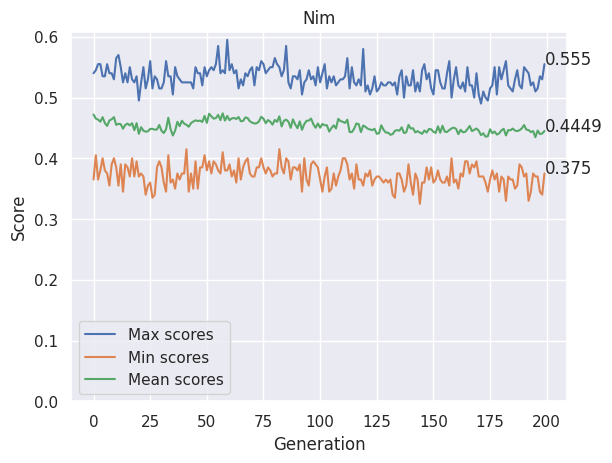

In [372]:
plot1(max_hist, min_hist, mean_hist)

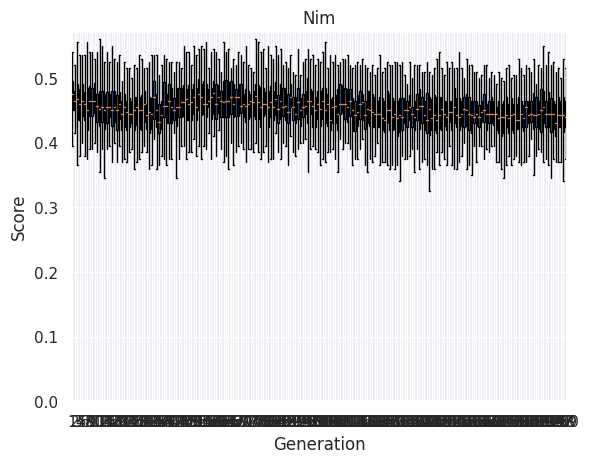

In [373]:
plot2(fitness_hist)

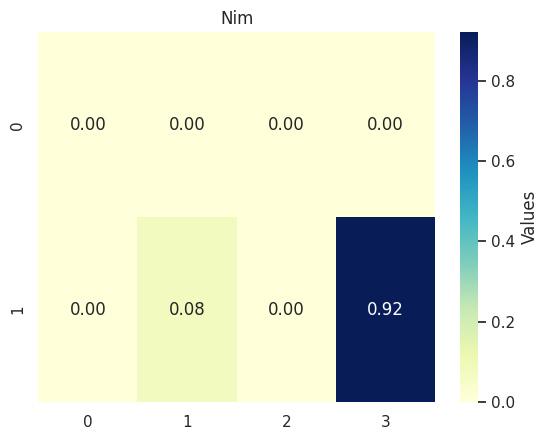

In [377]:
plot_heatmap(best_weights_hist)

In [378]:
fitness_scores = [fitness(lambda x: rule_based_strategy(x, weights=i["weights"])) for i in population]
i = np.argmax(fitness_scores)
best_weights = population[i]["weights"]
print("Best Agent =", best_weights)
print("Fitness =", fitness(lambda x: rule_based_strategy(x, weights=best_weights), num_matches=1000, difficulty=1.0))

Best Agent = [0. 1. 0. 0. 0. 1.]
Fitness = 0.445


# Real match

In [379]:
logging.getLogger().setLevel(logging.INFO)

MATCH_NUM = 1000

strategy = (lambda x: rule_based_strategy(x, weights=best_weights), optimal)

res = []
for _ in range(MATCH_NUM):
    nim = Nim(NIM_DIM)
    player = 0
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player
    res.append(1 - player)

print(f"Win rate = {np.array(res).mean()}")

Win rate = 0.465
